In [10]:
# extract fire
import imutils
import cv2
import numpy as np
# remove small object noise
from skimage import io, morphology

# save to tif
from PIL import Image

# georeference
import shutil
from osgeo import gdal, osr

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
### process images to get a list of each frame
col_images = []
vs = cv2.VideoCapture("CampFire_AMPM_NCAR.mp4")

for i in range(450):
    ret, frame = vs.read()
    frame = imutils.resize(frame, width=500)
    col_images.append(frame)

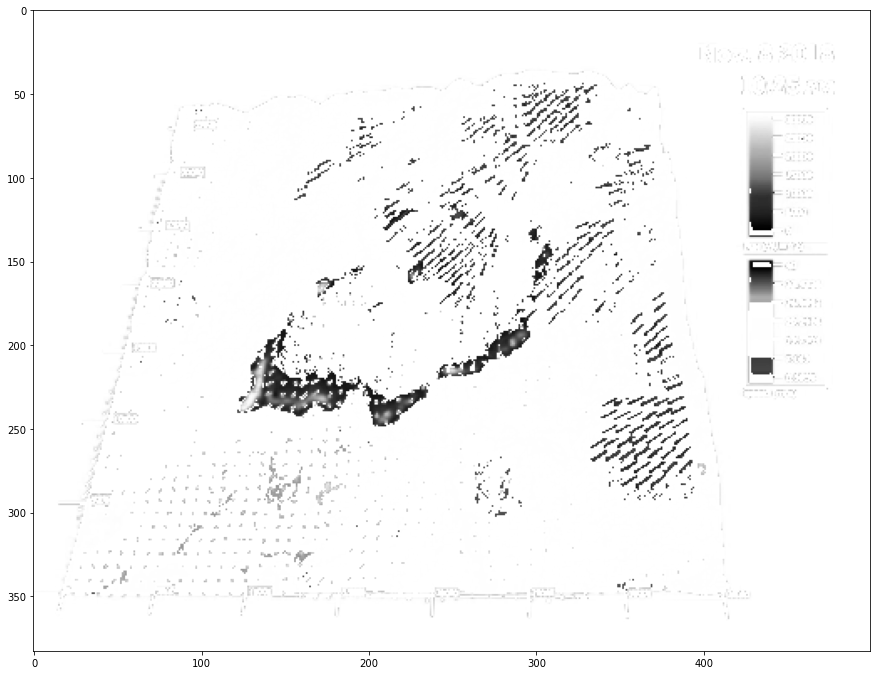

In [16]:
### get dilated images
def get_diff_image(i, draw_plot=False):

    # change the image rgb order
    img = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2RGB)
    # img = img[280:350, 700:750, :]
    
    # keep these colors
    red_thresh = cv2.inRange(img, np.array([0, 0, 20]), np.array([50, 255, 255]))
    green_thresh = cv2.inRange(img, np.array([0, 100, 0]), np.array([200, 255, 255]))
    marker_thresh = cv2.inRange(img, np.array([50, -1, 0]), np.array([220, 1, 45]))
    dark_thresh = cv2.inRange(img, np.array([0, 0, 0]), np.array([100, 200, 200]))

    combined_mask = red_thresh + green_thresh + marker_thresh + dark_thresh
    combined_mask_rgb = cv2.cvtColor(combined_mask, cv2.COLOR_GRAY2RGB)

    color = cv2.max(img, combined_mask_rgb)
    gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
    gray[165:180, 160:170] = 255
    
    if draw_plot:
        with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black'}):
            plt.figure(figsize=(15,15))
            plt.imshow(gray, cmap='gray')
            plt.show()
    
    return img, gray

img, gray = get_diff_image(250, draw_plot=True)

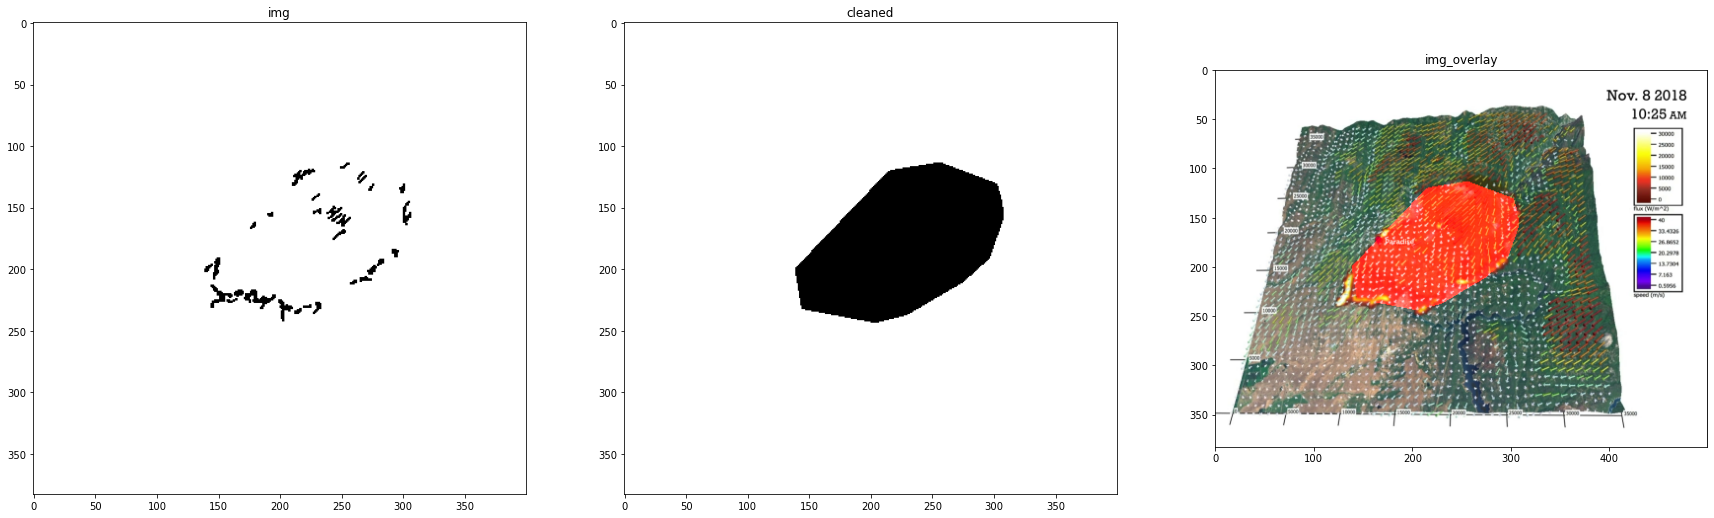

In [20]:
def fire_contour(img, gray, prev_chull=None, draw_plot=False):
    
    # cut off the legend part
    crop_gray = gray[:, 0:400]
    # smooth
    kernel = np.ones((2,2),np.uint8)
    dilated = cv2.dilate(255-crop_gray,kernel,iterations = 1)
    ret, thresh = cv2.threshold(dilated, 200, 255, cv2.THRESH_BINARY)
    # remove noise
    arr = thresh > 0
    cleaned = morphology.remove_small_objects(arr, min_size=16)
    cleaned = morphology.remove_small_holes(cleaned, area_threshold=2)
    cleaned = cleaned.astype('uint8')*255
    # smooth again
    kernel2 = np.ones((2,2),np.uint8)
    dilated2 = cv2.dilate(cleaned,kernel2,iterations = 1)
    # convex hull
    chull = morphology.convex_hull_image(dilated2)
    if prev_chull is not None:
        chull = np.logical_or(chull, prev_chull)
    # apply the overlay
    # https://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    chull_img = img.copy()
    chull_color = chull.astype('uint8')*255
    chull_color = cv2.copyMakeBorder( chull_color, 0, 0, 0, 100, cv2.BORDER_CONSTANT)
    chull_color = cv2.cvtColor(chull_color, cv2.COLOR_GRAY2RGB)
    chull_color[:,:,1] = 0 ### set green band to zero
    chull_color[:,:,2] = 0 ### set blue band to zero
#     print(chull_color.shape, chull_img.shape)
    chull_img = cv2.addWeighted(chull_color, 0.9, chull_img, 1, 0, chull_img)
    
    if draw_plot:
        fig, axs = plt.subplots(1, 3, figsize=(30, 10))
        axs[0].imshow(cleaned, cmap='gray_r')
        axs[0].set_title('img')
        axs[1].imshow(chull, cmap='gray_r')
        axs[1].set_title('cleaned')
        axs[2].imshow(chull_img)
        axs[2].set_title('img_overlay')
        plt.show()
    
    return chull, chull_img

chull, chull_img = fire_contour(img, gray, draw_plot=True)

In [14]:
### reference: https://stackoverflow.com/questions/55681995/how-to-georeference-an-unreferenced-aerial-image-using-ground-control-points-in

def save_geotiff(img, timestamp):
    im = Image.fromarray(img)
    orig_fn = 'cawfe_fire_tif/tmp.tif'
    im.save(orig_fn)
    
    output_fn = 'cawfe_fire_tif/cawfe_fire_{}.tif'.format(timestamp)
    # Create a copy of the original file and save it as the output filename:
    shutil.copy(orig_fn, output_fn)
    # Open the output file for writing for writing:
    ds = gdal.Open(output_fn, gdal.GA_Update)
    # Set spatial reference:
    sr = osr.SpatialReference()
    sr.ImportFromEPSG(4326) # WGS 84 or UTM Zone 10

    # Enter the GCPs
    #   Format: [map x-coordinate(longitude)], [map y-coordinate (latitude)], [elevation],
    #   [image column index(x)], [image row index (y)]
    """
    Control Points
    (143, 727), (39.639094, -121.713908)
    (627, 642), (39.667799, -121.496260)
    (716, 320), (39.8134, -121.4347)
    """

    gcps = [gdal.GCP(-121.713908, 39.639094, 0, 143/1240*500, 727/1240*500),
    gdal.GCP(-121.496260, 39.667799, 0, 627/1240*500, 642/1240*500),
    gdal.GCP(-121.4347, 39.8134, 0, 716/1240*500, 320/1240*500)]

    # Apply the GCPs to the open output file:
    ds.SetGCPs(gcps, sr.ExportToWkt())
    gdal.Warp(output_fn, ds, dstSRS='EPSG:4326', format='gtiff')

    # Close the output file in order to be able to work with it in other programs:
    ds = None
    

In [21]:
prev_chull = None
for t in range(250, 450, 5):
    img, gray = get_diff_image(t)
    chull, chull_img = fire_contour(img, gray, prev_chull)
    save_geotiff(chull, t)
    save_geotiff(chull_img, 'img_{}'.format(t))
    prev_chull = chull

IndexError: list index out of range

### Find links in fire area

In [1]:
import pandas as pd 
import numpy as np
import rasterio as rio
import rasterio.features
import geopandas as gpd
from shapely.wkt import loads
from matplotlib import pyplot as plt

(431, 474)
(431, 474)


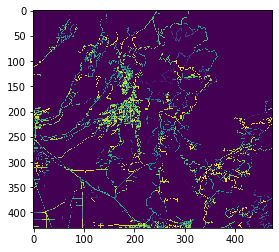

In [2]:
# read raster template
raster_template = rio.open('cawfe_fire_tif/cawfe_fire_80.tif')
print(raster_template.shape)

# read links file to be rasterized
links = pd.read_csv('../../network_inputs/butte_edges_sim.csv')
links = gpd.GeoDataFrame(links, crs='epsg:4326', geometry=links['geometry'].map(loads))
display(links.head(2))

# rasterize the links
raster_links = rasterio.features.rasterize(
    [(getattr(row, 'geometry'), getattr(row, 'eid')) for row in links.itertuples()],
    transform=raster_template.transform,
    out_shape=raster_template.shape)
print(raster_links.shape)
plt.imshow(raster_links, interpolation='nearest')
plt.show()

# output raster layer
with rasterio.open(
    '../../network_inputs/butte_edges_sim.tif',
    'w',
    driver='GTiff',
    height=raster_links.shape[0],
    width=raster_links.shape[1],
    count=1,
    dtype=raster_links.dtype,
    crs='+proj=latlong',
    transform=raster_template.transform,
) as dst:
    dst.write(raster_links, 1)

(431, 474)


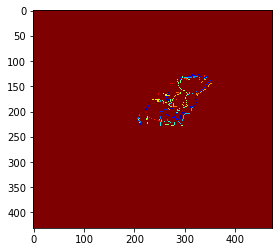

In [5]:
# read raster template
time_step = 165
raster_fire = rio.open('cawfe_fire_tif/cawfe_fire_{}.tif'.format(time_step))
print(raster_fire.shape)
fire_array = raster_fire.read(1) # get first band, use raster_fire.indexes --> total # bands
# links in fire
links_in_fire = np.where(fire_array==0, 0, raster_links)
plt.imshow(links_in_fire, interpolation='nearest')
plt.show()

### Random generation

In [6]:
import pandas as pd 
import numpy as np
import rasterio as rio
import rasterio.features
import rasterio.mask
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import Polygon
from matplotlib import pyplot as plt

In [7]:
### make raster file of the selected area
polygon = Polygon([(-121.56, 39.88), (-121.56, 39.72), (-121.66, 39.72), (-121.66, 39.88)])
with rasterio.open("cawfe_fire_tif/cawfe_fire_80.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, [polygon], crop=True)
    out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
fire = np.zeros_like(out_image[0])
(x_range, y_range) = fire.shape
print(x_range, y_range)
print(out_transform)

153 96
| 0.00, 0.00,-121.66|
| 0.00,-0.00, 39.88|
| 0.00, 0.00, 1.00|


In [8]:
total_fire_steps = 3 ### no. steps to gradually move fire towards the west side
y_step_size = int(y_range/total_fire_steps)
new_spots = 50
secondary_spot_distance = 10
primary_step = int(3600/total_fire_steps)
secondary_step = 300

fire_step = 0
for t in range(0, 7200):
    if t%primary_step == 0:
        # locations for the first fire
        x_fire = np.random.randint(0, x_range, new_spots)
        y_fire = np.random.randint(y_range-(fire_step+1)*y_step_size, y_range-fire_step*y_step_size, new_spots)
        fire[x_fire, y_fire]=1
        fire_step += 1
    if t%secondary_step == 0:
        x_fire, y_fire = np.nonzero(fire)
        # sprout secondary fire
        x_fire_secondary_tmp = x_fire + np.random.randint(-secondary_spot_distance, secondary_spot_distance, len(x_fire))
        y_fire_secondary_tmp = y_fire + np.random.randint(-secondary_spot_distance, secondary_spot_distance, len(y_fire))
        # filter out secondary fire out of the raster range
        x_fire_secondary = x_fire_secondary_tmp[(x_fire_secondary_tmp>=0) & (x_fire_secondary_tmp<x_range) 
            & (y_fire_secondary_tmp>=0) & (y_fire_secondary_tmp<y_range)]
        y_fire_secondary = y_fire_secondary_tmp[(x_fire_secondary_tmp>=0) & (x_fire_secondary_tmp<x_range) 
            & (y_fire_secondary_tmp>=0) & (y_fire_secondary_tmp<y_range)]
        # set secondary fire
        fire[x_fire_secondary, y_fire_secondary]=1
        # plot fire locations
        # plt.imshow(fire, interpolation='nearest')
        # plt.show()
        
        # output raster layer
        with rasterio.open(
            'random/random_fire_t{}.tif'.format(t),
            'w',
            driver='GTiff',
            height=fire.shape[0],
            width=fire.shape[1],
            count=1,
            dtype=fire.dtype,
            crs='+proj=latlong',
            transform=out_transform,
        ) as dst:
            dst.write(fire, 1)

In [1]:
import numpy as np 
import matplotlib as mpl        
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# reproject fire data
import rioxarray
import xarray
import rasterio

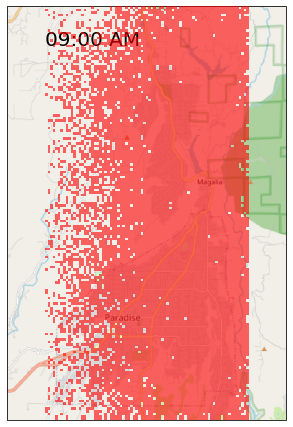

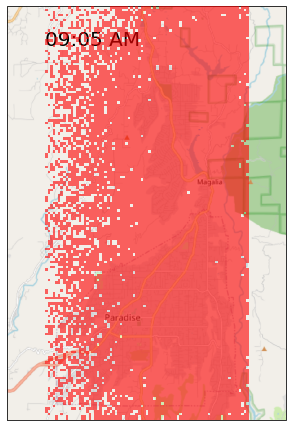

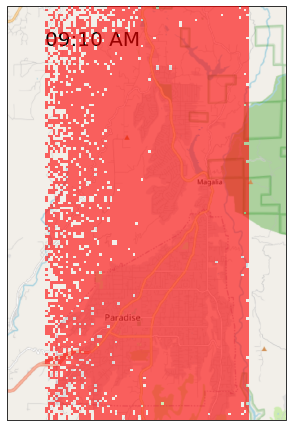

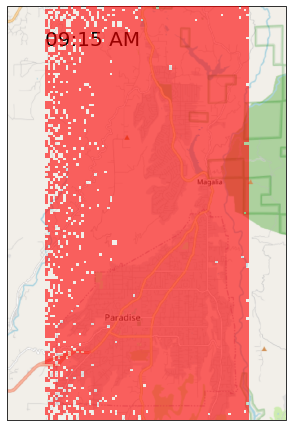

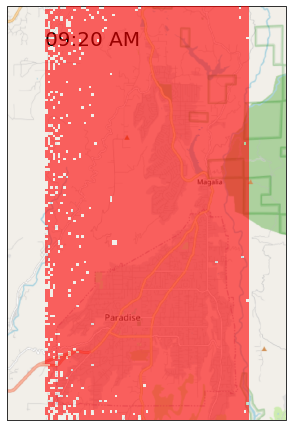

In [45]:
# OSM basemap
request = cimgt.OSM()

for t in range(3600, 5000, 300):
    fig, ax = plt.subplots(figsize=(5,8), subplot_kw=dict(projection=ccrs.Mercator()))
    xds = xarray.open_rasterio(r"random/random_fire_t{}.tif".format(t))
    xds.rio.reproject(ccrs.Mercator().proj4_params).rio.to_raster("random/random_fire_mercator.tif")
    fire = rasterio.open("random/random_fire_mercator.tif")
    ul_lon, ul_lat = fire.transform * (0,0)
    lr_lon, lr_lat = fire.transform * (fire.width, fire.height)
    extent_fire = [ul_lon, lr_lon, lr_lat, ul_lat]

    extent = [-121.68, -121.54, 39.72, 39.88]  # (xmin, xmax, ymin, ymax)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_image(request, 12)
    fire_masked = np.ma.masked_where(fire.read(1) == 0, fire.read(1))
    cmap = mpl.colors.ListedColormap(['red'])
    bounds=[0.5, 1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    ax.imshow(fire_masked, cmap=cmap, norm=norm, interpolation='nearest', origin='upper', alpha=0.6, extent=extent_fire, zorder=10)
    ax.text(extent_fire[0], extent_fire[3]-(extent_fire[3]-extent_fire[2])/10, '{:02d}:{:02d} AM'.format(t//3600+8, (t%3600)//60), size=20)

    plt.savefig('random_image/random_fire_{}.png'.format(t))

In [47]:
import imageio
with imageio.get_writer('random_image/random_fire.gif', mode='I', duration=0.5) as writer:
    for t in range(0, 3900, 300):
        image = imageio.imread('random_image/random_fire_{}.png'.format(t))
        writer.append_data(image)

### CAWFE and spot fire

In [ ]:
import pandas as pd 
import numpy as np
import rasterio as rio
import rasterio.features
import geopandas as gpd
from shapely.wkt import loads
import matplotlib as mpl  
from matplotlib import pyplot as plt

75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200


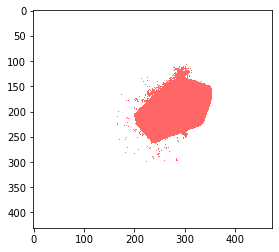

205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445


In [99]:
def create_secondary_spot_fire(spot_fire, secondary_fire_ratio, secondary_ember_count):
    spot_fire_x = np.nonzero(spot_fire)[0]
    spot_fire_y = np.nonzero(spot_fire)[1]
    # only some spot fire will create new ones
    secondary_spot_fire_mask = np.random.choice([0,1], size=len(spot_fire_x), p=[1-secondary_fire_ratio, secondary_fire_ratio])
    spot_fire_x = spot_fire_x[secondary_spot_fire_mask==1]
    spot_fire_y = spot_fire_y[secondary_spot_fire_mask==1]
    for i in range(secondary_ember_count):
        secondary_ember_angle = np.random.uniform(-180, 180, len(spot_fire_x))
        secondary_ember_distance = np.random.uniform(0, 5, len(spot_fire_x))
        secondary_ember_location_x = spot_fire_x + np.cos(secondary_ember_angle/180*np.pi)*secondary_ember_distance
        secondary_ember_location_y = spot_fire_y + np.sin(secondary_ember_angle/180*np.pi)*secondary_ember_distance
        secondary_ember_location_x = np.minimum(spot_fire.shape[0]-1, np.maximum(0, secondary_ember_location_x))
        secondary_ember_location_y = np.minimum(spot_fire.shape[1]-1, np.maximum(0, secondary_ember_location_y))
        spot_fire[secondary_ember_location_x.astype(int), secondary_ember_location_y.astype(int)] = 1
    return spot_fire
    
def create_spot_fire(main_fire, spot_fire, ember_count, secondary_fire_ratio, secondary_ember_count):
    main_fire_cx, main_fire_cy = np.mean(np.nonzero(main_fire)[0]), np.mean(np.nonzero(main_fire)[1])
    main_fire_lx = np.max(np.nonzero(main_fire)[0]) - np.min(np.nonzero(main_fire)[0])
    for i in range(ember_count):
        # random angle along -45 degree
        ember_angle = np.random.normal(-55, 30)
        # random distance with the longest along -45 degree
        ember_distance = np.random.uniform(main_fire_lx, np.abs(np.max([100,main_fire_lx])-np.abs(ember_angle+55)*2))
        # fire location
        ember_location_x = main_fire_cx + np.cos(ember_angle/180*np.pi) * ember_distance
        ember_location_y = main_fire_cy + np.sin(ember_angle/180*np.pi) * ember_distance
        # filter those outside of the picture
        ember_location_x = np.min([main_fire.shape[0]-1, np.max([0, ember_location_x])])
        ember_location_y = np.min([main_fire.shape[1]-1, np.max([0, ember_location_y])])
        # newly ignited spot fire
        spot_fire[int(ember_location_x), int(ember_location_y)] = 1
    spot_fire = create_secondary_spot_fire(spot_fire, secondary_fire_ratio, secondary_ember_count)
    return spot_fire

main_fire = rio.open('cawfe_fire_tif/cawfe_fire_75.tif').read(1)
spot_fire = np.zeros_like(main_fire)
raster_template = rio.open('cawfe_fire_tif/cawfe_fire_80.tif')

# read raster template
for t in range(75, 450, 5):
    print(t)
    main_fire = rio.open('cawfe_fire_tif/cawfe_fire_{}.tif'.format(t)).read(1)
    spot_fire = create_spot_fire(main_fire, spot_fire, 10, 0.2, 2)
    all_fire = np.where(spot_fire+main_fire>=1, 1, 0)
    
    # draw images
    if t==200:
        cmap = mpl.colors.ListedColormap(['white', 'red'])
        bounds=[0, 0.5, 2]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        plt.imshow(all_fire, interpolation='none', cmap=cmap, norm=norm, alpha=0.6)
        plt.show()

    # output raster layer
#     all_fire = all_fire.astype(np.int32)
#     with rasterio.open(
#         'cawfe_fire_tif/cawfe_spot_fire_{}.tif'.format(t),
#         'w',
#         driver='GTiff',
#         height=all_fire.shape[0],
#         width=all_fire.shape[1],
#         count=1,
#         dtype=all_fire.dtype,
#         crs='+proj=latlong',
#         transform=raster_template.transform,
#     ) as dst:
#         dst.write(all_fire, 1)